<a href="https://colab.research.google.com/github/madhugopinathan/madhugopinathan.github.io/blob/master/notebooks/deep-nlu/introduction_to_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Natural Language Processing

In this session, we'll learn about the basic concepts of Natural Language Processing (NLP) using a restaurant reviews dataset from Yelp. 


1.   [Distributional Hypothesis](https://aclweb.org/aclwiki/Distributional_Hypothesis): *A word is characterized by the company it keeps*
2.   [Vector Semantics](https://web.stanford.edu/~jurafsky/slp3/6.pdf): How to implement the above idea to get a computer to learn the meanings of words directly from text?
3. Co-occurrence Matrix: A data structure to hold the counts of how often words co-occur in a given text
4. Transforming Raw Counts: Methods to transform raw counts in the above matrix to extract useful information

*Note: if you're running this in Google Colab, please save the notebook to your drive first before executing it.*


In [1]:
!wget https://s3.amazonaws.com/fast-ai-nlp/yelp_review_full_csv.tgz
!tar xvfz yelp_review_full_csv.tgz
#

--2021-01-26 08:36:35--  https://s3.amazonaws.com/fast-ai-nlp/yelp_review_full_csv.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.100.150
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.100.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 196146755 (187M) [application/x-tar]
Saving to: ‘yelp_review_full_csv.tgz’

yelp_review_full_cs 100%[===================>] 187.06M  40.0MB/s    in 4.9s    

2021-01-26 08:36:40 (38.1 MB/s) - ‘yelp_review_full_csv.tgz’ saved [196146755/196146755]

yelp_review_full_csv/
yelp_review_full_csv/train.csv
yelp_review_full_csv/readme.txt
yelp_review_full_csv/test.csv


In [2]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import svds
import pandas as pd
import seaborn as sns
import spacy
nlp = spacy.load('en')
pd.options.display.max_colwidth=-1
#

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  # This is added back by InteractiveShellApp.init_path()


## Browse Restaurant Reviews from Yelp


In [3]:
DATA_DIR = "./yelp_review_full_csv/"
df = pd.read_csv(DATA_DIR + "train.csv", header=None, names=['rating', 'review'])
df[df.review.str.contains("indian")].sample(3)
#

,rating,review
390204,5,Best indian food in vegas. We always go here and this food is delicious and authentic
451713,5,"Got to be a high five for Mother India. Myself and a few old workmates - having all four of us gone our separate ways from the Citi arena - now congregate monthly for a Tuesday Curry Club. The idea was to try a different place every month. We've been going for two months now.... this place both times. Now I'm worried we may never see another indian restaurant.\n\nBut in fairness if going to Mother India once a month is a worry, I don't know what I'm smoking! It's tremendous, setting itself up as an Indian Tapas deal, meaning you get to try a bunch of dishes at the same time, as opposed to the standard sit-down affair offered by other restaurants en masse.\n\nGood thing about Tuesday Curry Club (besides the curry) is that it consists of 4 growing boys with healthy appetites. With so much on offer, it means we can get away with ordering a ridiculous amount of food, and with the tapas style we can order even more if we feel we've under-supplied ourselves.\n\nWhat did we have, what did we have? There was....\n\n- Lamb Karahi\n- Chilli Garlic Chicken\n- Chilli Chicken Dosa\n- Baby Aubergine and Potatoes\n- Vegetable Pakora\n- Chicken Breast Curry\n- Chilli King Prawns (so good we ordered 2 portions)\n- Mutton Curry (Daily special, of which there are 5.... daily!)\n- Peshwari Naan\n- Garlic Naan\n- Paratha\n- Rice\n\nWe had so much food we couldn't see the table. We had so much food we had to admit defeat, leaving some pakora and aubergine to be returned while we hung our heads in shame.\n\nConsidering we got all the above plus soft drinks for \u00a325 a head (3 people; 1 of us had to work late sadly), shows what a bargain Mother India is.\n\nAlways busy so book ahead. Staff are delightful, chatty and happy to leave you to it once your food's down.\n\nA must try for lovers of Indian cuisine.\n\nTuesday Curry Club, December location?..... you guessed it!"
37925,1,"Rip-off artists.\n\n I only used them cuz they were on my (cheaper) dental plan from Aetna. They make stuff up that's wrong that's kind of iffy, that any ethical dentist would say, no, you don't need a root canal, but if you needed anything, we would try to take out the filling and re-fill it first. They try to sell you this stuff cuz the insurance makes no $ from the regular cleanings and they have to make some $ somehow, so they fabricate stuff that's not ready to be done yet on your teeth. AND, this dental assistant was very rude. indian woman. \n\nAlso, the other girl my son had--she was quite nice, but not too competent. she wrote the wrong info down about what work my son needed done! supposed to be teeth A & B, and ended up as 8 and 13 on their chart! so, when I went for a 2nd opinion back to our old dentist 45 min away, he said nothing wrong with 8 or 13! and when I called to let Southwest have it, the original dentist said it was mismarked on the chart and she said A & B."


## Extract cuisines using Named Entity Recognition (NER)

The restaurants that are reviewed serve a variety of cuisines. Typically, the words denoting cuisine type (indian, chinese, mexican etc.) are the same as nationalities. So we'll use a model called *named entity recognition* implemented in [Spacy](https://spacy.io/) to extract these cuisine tokens. As an example, let's extract tokens of type GPE and NORP.

*   GPE: Geo-political entity
*   NORP: Nationalities, religious, political groups



In [4]:
text = """Definitely not the best Indian food I have had. 
          Good for them they are in Vegas where other Indian restaurants 
          are pretty bad as well."""
doc = nlp(text)
for ent in doc.ents:
    print(ent.label_, ent.lower_, ent.start, ent.end)


NORP indian 4 5
GPE vegas 17 18
NORP indian 20 21


In [5]:
doc[4:5], doc[17:18]

(Indian, Vegas)

## Build a cuisine **X** word co-occurrence matrix

Let's build a matrix with rows as cuisine tokens and the corresponding columns containing nearby words (within a window of size 10). As the rows and columns of the matrix are indexed by numbers, we need to construct the following maps.

*   cuisine2idx: map cuisine to index

    * idx2cuisine: map index to cuisine
    
*   token2idx: map other tokens to indices

    * idx2token: map index to token



In [6]:
def get_cuisine_idx(cuisine):
    return cuisine2idx.setdefault(cuisine, len(cuisine2idx))

def get_token_idx(token):
    return token2idx.setdefault(token, len(token2idx))

def build_cuisine_token_mat(df,ws=10):
    row = []
    col = []
    data = []
    
    def do_count_tokens(cuisine, tokens):
        for tok in tokens:
            if len(tok.ent_type_) > 0 or tok.is_stop or tok.is_punct:
                continue
            row.append(get_cuisine_idx(cuisine.lower_))
            col.append(get_token_idx(tok.lower_))
            data.append(1.)
    
    for doc in nlp.pipe(df.review):
        for ent in doc.ents:
            # NORP: nationalities, religious, political groups
            if ent.label_ == "NORP": 
                # count left side window
                do_count_tokens(ent, doc[ent.start-ws:ent.start]) 
                # count right side window
                do_count_tokens(ent, doc[ent.end:ent.end+ws])
    
    return sparse.csr_matrix((data, (row, col)), 
                             shape=(len(cuisine2idx), len(token2idx)))
#

In [7]:
%%time
np.random.seed(42)
cuisine2idx = {}
token2idx = {}
small_df = df.sample(20000)
cuisine_token_mat = build_cuisine_token_mat(small_df)
#

CPU times: user 4min 47s, sys: 7.14 s, total: 4min 55s
Wall time: 4min 55s


### Let's view the top 20 cuisines

(index, cuisine)

In [8]:
idx2token = {v:k for k,v in token2idx.items()}
idx2cuisine = {v:k for k,v in cuisine2idx.items()}

def get_top_cuisine_indices(mat,n):
    rowsum = np.squeeze(np.asarray(mat.sum(axis=1)))
    return np.argsort(rowsum)[::-1][:n]

for idx in get_top_cuisine_indices(cuisine_token_mat,20):
    print(idx,idx2cuisine[idx])
#

4 mexican
17 french
14 italian
16 chinese
2 thai
6 asian
9 \nthe
30 japanese
13 american
12 indian
0 greek
103 irish
5 vietnamese
83 korean
67 hawaiian
15 venetian
106 spanish
34 appetizer
64 polish
3 vegetarian


### And the top tokens that occur near cuisines

In [9]:
def get_top_token_indices(mat,n):
    rowsum = np.squeeze(np.asarray(mat.sum(axis=0)))
    return np.argsort(rowsum)[::-1][:n]
  
for idx in get_top_token_indices(cuisine_token_mat,20):
    print(idx,idx2token[idx])
#

4  
23 food
5 good
73 like
13 place
76 restaurant
37 great
105 ordered
419 better
22 salad
86 restaurants
255 service
251 chicken
560 best
29 menu
322 time
66 try
181 toast
352 fries
91 nice


### Co-occurrence matrices are typically sparse


In [14]:
print(f"Shape of cuisine x token: {cuisine_token_mat.shape}")
print(f"Number of non-zero entries: {cuisine_token_mat.nnz}")
print(f"Non-zero entries as a % of total size: {np.round(cuisine_token_mat.nnz/np.prod(cuisine_token_mat.shape) * 100,3)}%")
#

Shape of cuisine x token: (980, 7969)
Number of non-zero entries: 28028
Non-zero entries as a % of total size: 0.359%


### Visualize top cuisines x top tokens

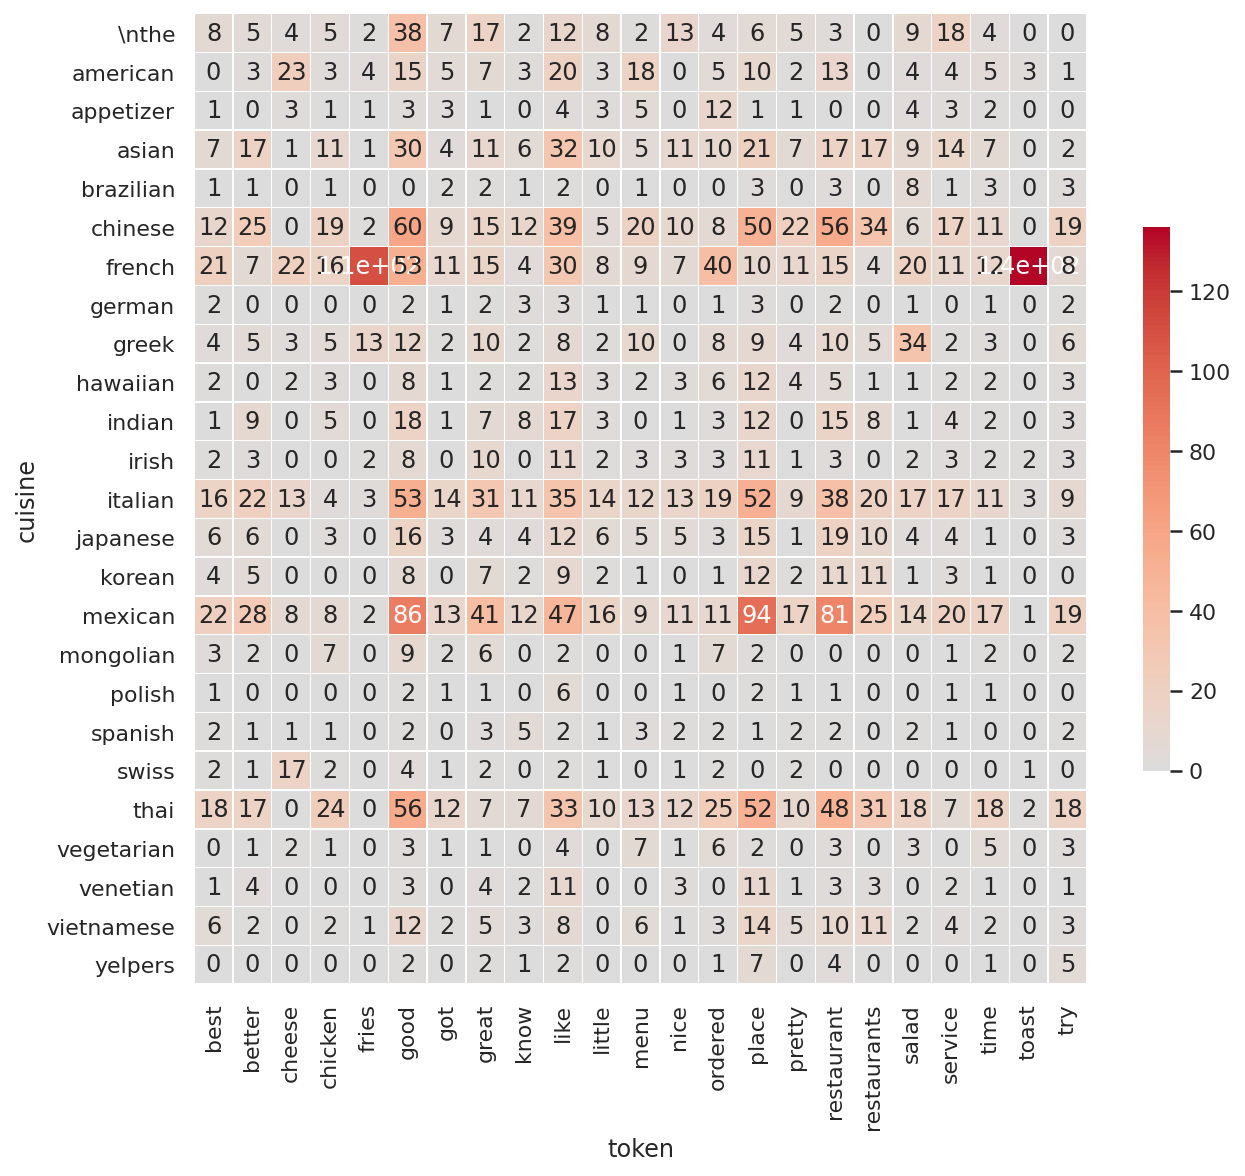

In [15]:
def get_cuisine_token_df(mat,n=25):
    cuisine_indices = get_top_cuisine_indices(mat, n)
    token_indices = get_top_token_indices(mat, n)

    data = []
    co_mat = np.zeros((len(cuisine_indices), len(token_indices)))
    for i,cidx in zip(range(n),cuisine_indices):
        for j, jidx in zip(range(n),token_indices):
            data.append((idx2cuisine[cidx], idx2token[jidx], 
                         cuisine_token_mat[cidx, jidx]))
            
    columns=['cuisine','token','freq']
    df = pd.DataFrame(data,columns=columns)
    return df.pivot(*columns)

ct_df = get_cuisine_token_df(cuisine_token_mat)
ct_df.drop(columns=[' ','food'], inplace=True)
fig = plt.figure(figsize=(10, 10))  
sns.set(style='white')  
ax = sns.heatmap(ct_df, 
                 cmap="coolwarm",
                 annot=True, 
                 center=0, square=True, 
                 linewidths=0.2,cbar_kws={"shrink": 0.5})
#

## Co-occurrence matrix reweighting using Pointwise Mutual Information


[Positive Pointwise Mutual Information](https://web.stanford.edu/~jurafsky/slp3/6.pdf)

*   See section 6.7
    
Pointwise mutual information is one of the most important concepts in NLP. It is a measure of how often two events x and y occur, compared with
what we would expect if they were independent.

\begin{align}
\text{PMI(w,c)} = \text{log}_2\frac{P(w,c)}{P(w)P(c)}
\end{align}



In [16]:
def pmi(xy, x, y, N):
    """
    Point-wise mutual information score of two events x, y
    N is the sample size of the universe.
    """
    return np.log2(xy) + np.log2(N) - np.log2(x) - np.log2(y)

        
def ppmi(xy, x, y, N, pmi_threshold):
    val = pmi(xy, x, y, N)
    return 0 if val < pmi_threshold else val


def build_ppmi_mat(csr_mat, count_threshold, pmi_threshold):
    below_threshold = np.sum(csr_mat.data < count_threshold)
    total = csr_mat.nnz
    print(f"Pct. of elements below count_threshold {below_threshold/total} / total {total}")

    csr_mat = csr_mat.copy()
    csr_mat.data[csr_mat.data < count_threshold] = 0
    csr_mat.eliminate_zeros()

    print(f"Number of elements after zeroing out data: {csr_mat.nnz}")

    coo = csr_mat.tocoo()
    rowsum = np.squeeze(np.asarray(coo.sum(axis=1)))
    colsum = np.squeeze(np.asarray(coo.sum(axis=0)))
    N = coo.sum()


    data = [ppmi(count, rowsum[r], colsum[c], N, pmi_threshold) 
            for r,c,count in zip(coo.row, coo.col, coo.data)]
    ppmi_csr = sparse.csr_matrix((data, (coo.row, coo.col)), shape=coo.shape)
    ppmi_csr.eliminate_zeros()
    return ppmi_csr
  
ppmi_mat = build_ppmi_mat(cuisine_token_mat, 3, 0.05)
#

Pct. of elements below count_threshold 0.9128371628371629 / total 28028
Number of elements after zeroing out data: 2443


### Co-occurrence vs. PMI

Let's compare the raw counts and the corresponding PMI values for a sample of (cuisine, token) pairs.

In [17]:
cuisines_tokens = [('indian','food'), 
                   ('indian','restaurant'), 
                   ('indian','spicy'),
                   ('indian','curry'),
                   ('indian','basmati')
                  ]
for c,t in cuisines_tokens:
  print(f"{c+' '+t:^48s}")
  cidx = cuisine2idx[c]
  tidx = token2idx[t]
  print(f"CO: {cuisine_token_mat[cidx, tidx]}, PPMI: {np.round(ppmi_mat[cidx, tidx], 2)}")
#

                  indian food                   
CO: 67.0, PPMI: 1.1
               indian restaurant                
CO: 15.0, PPMI: 0.79
                  indian spicy                  
CO: 5.0, PPMI: 3.15
                  indian curry                  
CO: 5.0, PPMI: 2.25
                 indian basmati                 
CO: 3.0, PPMI: 5.42


Let's also look at the common co-occurring tokens for some well known cuisines to see whether PMI gives a better result than raw counts.

In [19]:
def print_top_tokens_for_cuisine(mat, cuisine, n=10):
  cidx = cuisine2idx[cuisine]
  vec = mat[cidx]
  indices = np.argsort(vec.data)[::-1][:n]
  for idx in indices:
    print(idx2token[vec.indices[idx]], end=', ')

cuisines = ['indian','french','mexican','japanese']
for c in cuisines:
  print(f"{c:^48s}")
  print(f"{'Co-occurrence':^48s}")
  print_top_tokens_for_cuisine(cuisine_token_mat, c)
  print()
  print(f"{'PPMI':^48s}")
  print_top_tokens_for_cuisine(ppmi_mat, c)
  print("\n")
#

                     indian                     
                 Co-occurrence                  
food,  , good, like, restaurant, place, better, know, restaurants, buffet, 
                      PPMI                      
near, smell, middle, knows, naan, basmati, s, slightly, background, ended, 

                     french                     
                 Co-occurrence                  
 , toast, fries, good, ordered, food, bread, onion, soup, like, 
                      PPMI                      
enjoyed, ham, twice, honey, decided, brunch, shop, guess, +, baguette, 

                    mexican                     
                 Co-occurrence                  
food,  , place, good, restaurant, like, great, authentic, better, salsa, 
                      PPMI                      
having, saw, thinking, water, tortilla, fruit, yelp, ass, ordering, plenty, 

                    japanese                    
                 Co-occurrence                  
 , food, sushi, re

## Low Dimensional Representation of Cuisines

As we mentioned above, the co-occurrence matrix is typically sparse. In the data sample we've, as we're working with only cuisine tokens, this may not be a serious issue. However, when dealing with large number of tokens in the general case, we need to learn a low dimensional vector representation for each token. We'll demonstrate this below using a technique called Singular Value Decomposition (SVD) on the PMI matrix.  

In [20]:
U,S,VT = svds(ppmi_mat, k=30)
word_vectors = np.vstack((U,VT.T))
norm = np.linalg.norm(word_vectors,axis=1,keepdims=True)
norm_word_vectors = np.divide(word_vectors,norm,out=np.zeros_like(word_vectors), 
                              where=norm!=0)
def show_nearest_neighbours(cuisine, n=10):
  idx = cuisine2idx[cuisine]
    
  vec = norm_word_vectors[idx]
  for oidx in np.argsort(norm_word_vectors.dot(vec))[::-1][:n+1]:
    if oidx == idx:
      continue
    if oidx < len(idx2cuisine):
        print(idx2cuisine[oidx], end=', ')
    else:
        print(idx2token[oidx-len(idx2cuisine)], end=', ')
#

Let's now compare the co-occurring tokens for some popular cuisines (PMI vs. PMI + SVD)

In [21]:
cuisines = ['indian','french','mexican','japanese']
for c in cuisines:
  print(f"{c:^48s}")
  print(f"{'PPMI':^48s}")
  print_top_tokens_for_cuisine(ppmi_mat, c)
  print()
  print(f"{'PPMI + SVD':^48s}")
  show_nearest_neighbours(c)
  print("\n")
#

                     indian                     
                      PPMI                      
near, smell, middle, knows, naan, basmati, s, slightly, background, ended, 
                   PPMI + SVD                   
knows, smell, slightly, basmati, background, middle, s, naan, near, school, 

                     french                     
                      PPMI                      
enjoyed, ham, twice, honey, decided, brunch, shop, guess, +, baguette, 
                   PPMI + SVD                   
priced, warm, cinnamon, macaroons, manicure, awful, chef, topped, buttery, original, 

                    mexican                     
                      PPMI                      
having, saw, thinking, water, tortilla, fruit, yelp, ass, ordering, plenty, 
                   PPMI + SVD                   
burritos, hole, margarita, ass, tortilla, fruit, thinking, plenty, head, guacamole, 

                    japanese                    
                      PPMI        

# Recap


Words that occur in similar contexts tend to have similar
meanings. This link between similarity in how words are distributed and similarity
in what they mean is called the **distributional hypothesis**. The hypothesis was first formulated in the 1950s by linguists like Joos (1950), Harris (1954), and Firth (1957), who noticed that words which are synonyms (like oculist and eye-doctor) tended to occur in the same environment (e.g., near words like eye or examined) with the amount of meaning difference between two words “corresponding roughly to the amount of difference in their environments”.

**[You shall know a word by the company it keeps](https://en.wikipedia.org/wiki/John_Rupert_Firth)**

A **vector semantics model** instantiates this linguistic hypothesis by learning representations of the meaning of words directly from their distributions in texts. These representations are used in every natural language processing application that makes use of meaning. 

An important focus of recent NLP research is **representation learning**, i.e. unsupervised methods to learn vector representations of the input, instead of creating representations manually by feature engineering.

For more details, please refer [Chapter 6](https://web.stanford.edu/~jurafsky/slp3/6.pdf) of Speech and Language Processing: Daniel Jurafsky & James H Martin.
